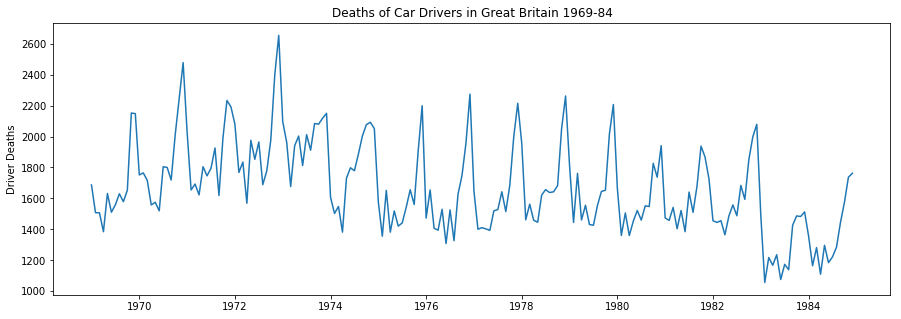

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示


data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv')
data.index = data['time']

# plt.figure(figsize=(15, 5))
# plt.plot(data.index, data['value'])
# plt.ylabel('Driver Deaths')
# plt.title('Deaths of Car Drivers in Great Britain 1969-84')
# plt.plot()
# data_d = data['value']


data.loc[(data['time']>=1983.05), 'seat_belt'] = 1;
data.loc[(data['time']<1983.05), 'seat_belt'] = 0;
data.loc[(data['time']>=1974.00), 'oil_crisis'] = 1;
data.loc[(data['time']<1974.00), 'oil_crisis'] = 0;
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['value'])
plt.ylabel('Driver Deaths')
plt.title('Deaths of Car Drivers in Great Britain 1969-84')
plt.plot()

df_drivers = pd.DataFrame({'drivers': data['value']})
df_seat_belt = pd.DataFrame({'seat_belt': data['seat_belt']})




In [3]:
df_drivers.head()


,drivers
time,
1969.000000,1687
1969.083333,1508
1969.166667,1507
1969.250000,1385
1969.333333,1632


In [4]:
df_seat_belt.head()

,seat_belt
time,
1969.000000,0.0
1969.083333,0.0
1969.166667,0.0
1969.250000,0.0
1969.333333,0.0


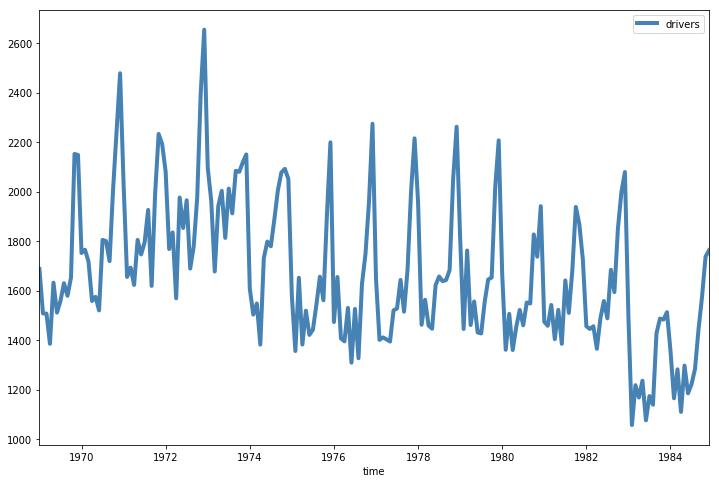

In [5]:
# プロット
plt.rcParams['figure.figsize'] = 12, 8
df_drivers.plot(linewidth=4, color="steelblue")


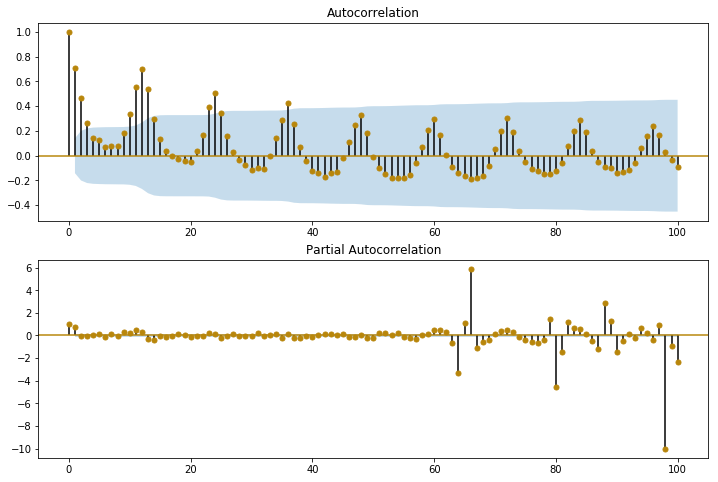

In [6]:
# 1. 自己相関と季節効果の確認
# 自己相関係数と偏自己相関係数のコレログラムを出力
fig,ax = plt.subplots(2,1,figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df_drivers, lags=100, ax=ax[0], color="darkgoldenrod")
fig = sm.graphics.tsa.plot_pacf(df_drivers, lags=100, ax=ax[1], color="darkgoldenrod")


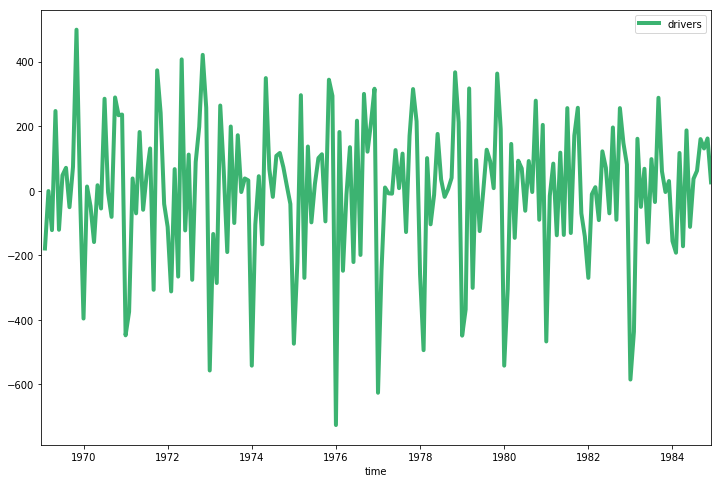

In [7]:
# 2. 定常性と単位根の確認
# wauの1次差分系列
plt.rcParams['figure.figsize'] = 12, 8
df_drivers.diff().plot(linewidth=4, color="mediumseagreen")

In [8]:
# 原系列に対するADF検定
results = sm.tsa.stattools.adfuller(df_drivers["drivers"])
print('ADF Statistic: %f' % results[0])
print('P-Value: %f' % results[1])

# P値>0.05となり、単位根過程であるという帰無仮説を棄却できなかった

ADF Statistic: -1.087861
P-Value: 0.719889


AttributeError: 'Float64Index' object has no attribute 'inferred_freq'

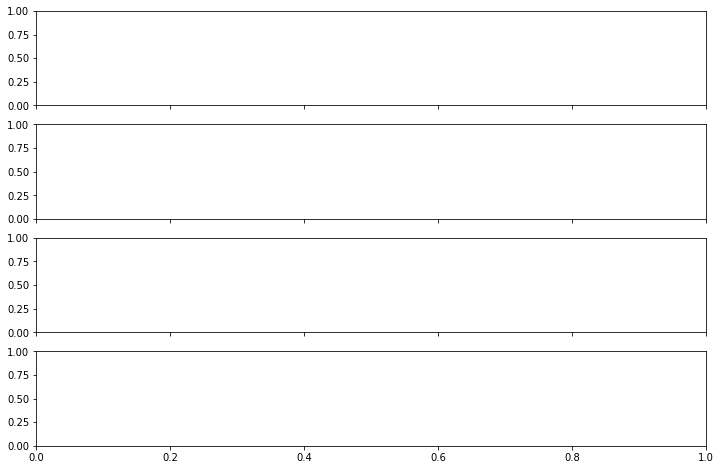

In [9]:
# # 3. トレンド(と季節成分)の抽出
# # トレンド成分と季節成分, 残差を抽出する
# fig, axes = plt.subplots(4, 1, sharex=True)

# decomposition = sm.tsa.seasonal_decompose(df_drivers, model ='additive')
# decomposition.observed.plot(ax=axes[0], legend=False, color='r')
# axes[0].set_ylabel('Observed')
# decomposition.trend.plot(ax=axes[1], legend=False, color='g')
# axes[1].set_ylabel('Trend')
# decomposition.seasonal.plot(ax=axes[2], legend=False)
# axes[2].set_ylabel('Seasonal')
# decomposition.resid.plot(ax=axes[3], legend=False, color='k')
# axes[3].set_ylabel('Residual')


In [11]:
# 考えられるパラメータの組み合わせを全て作成
max_p = 2
max_d = 1
max_q = 1
max_sp = 1
max_sd = 1
max_sq = 1
params = []

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1): 
                    for sq in range(0, max_sq + 1): 
                        params.append([p,d,q,sp,sd,sq])
params[:3]         

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0]]

In [12]:

# 最終的に予測したいのは繁忙期である1~3月のWAUのため, テスト期間も繁忙期に合わせる
df_drivers_s = df_drivers.head(225)
df_seat_belt_s = df_seat_belt.head(225)

# テストするため, 学習用とテスト用データの分割
y_train, y_test = df_drivers_s.head(210), df_drivers_s.tail(15)
X_train, X_test = df_seat_belt_s.head(210), df_seat_belt_s.tail(15)

# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=X_train, trend="n", freq='W', order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], 52), enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   

ValueError: Given index could not be coerced to dates but `freq` argument was provided.